In [7]:
import pandas as pd
import numpy as np
from googleapiclient.discovery import build
import google_auth_oauthlib.flow
import googleapiclient.discovery
import googleapiclient.errors
import isodate
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
    #Читаем наш исходный датафрейм
df = pd.read_csv('datasets/Usvideos.csv')
df

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40944,BZt0qjTWNhw,18.14.06,The Cat Who Caught the Laser,AaronsAnimals,15,2018-05-18T13:00:04.000Z,"aarons animals|""aarons""|""animals""|""cat""|""cats""...",1685609,38160,1385,2657,https://i.ytimg.com/vi/BZt0qjTWNhw/default.jpg,False,False,False,The Cat Who Caught the Laser - Aaron's Animals
40945,1h7KV2sjUWY,18.14.06,True Facts : Ant Mutualism,zefrank1,22,2018-05-18T01:00:06.000Z,[none],1064798,60008,382,3936,https://i.ytimg.com/vi/1h7KV2sjUWY/default.jpg,False,False,False,NaN
40946,D6Oy4LfoqsU,18.14.06,I GAVE SAFIYA NYGAARD A PERFECT HAIR MAKEOVER ...,Brad Mondo,24,2018-05-18T17:34:22.000Z,I gave safiya nygaard a perfect hair makeover ...,1066451,48068,1032,3992,https://i.ytimg.com/vi/D6Oy4LfoqsU/default.jpg,False,False,False,I had so much fun transforming Safiyas hair in...
40947,oV0zkMe1K8s,18.14.06,How Black Panther Should Have Ended,How It Should Have Ended,1,2018-05-17T17:00:04.000Z,"Black Panther|""HISHE""|""Marvel""|""Infinity War""|...",5660813,192957,2846,13088,https://i.ytimg.com/vi/oV0zkMe1K8s/default.jpg,False,False,False,How Black Panther Should Have EndedWatch More ...


In [5]:
#Число уникальных видео
df['video_id'].nunique()

6351

In [ ]:
# Парсим название канала(точнее id канала) и число подписчиков через ютуб api
API_KEY = 'ahahahahah'

# Создаем клиент YouTube API
youtube = build('youtube', 'v3', developerKey=API_KEY)


# Создаем пустые столбцы для channel_id и subscribers
df['channel_id'] = ''
df['subscribers'] = 0

# Итерируемся по уникальным video_id и получаем информацию о каналах
unique_video_ids = df['video_id'].unique()
for video_id in unique_video_ids:
    try:
        # Запрашиваем информацию о видео
        video_response = youtube.videos().list(
            part='snippet',
            id=video_id
        ).execute()

        # Извлекаем ID канала и количество подписчиков
        channel_id = video_response['items'][0]['snippet']['channelId']
        channel_response = youtube.channels().list(
            part='statistics',
            id=channel_id
        ).execute()
        subscribers = int(channel_response['items'][0]['statistics']['subscriberCount'])

        # Обновляем значения в датафрейме
        df.loc[df['video_id'] == video_id, 'channel_id'] = channel_id
        df.loc[df['video_id'] == video_id, 'subscribers'] = subscribers
    except Exception as e:
        print(f"Error for video {video_id}: {e}")

# Сохраняем обновленный датафрейм
#df.to_csv('updated_dataframe.csv', index=False)

In [ ]:
#читаем наш запарсенный датафрейм
df = pd.read_csv('updated_dataframe.csv')

In [ ]:
#убираем пустые строки(строки с ошибкой(удаленные видео))
df = df[df['channel_id'].notnull() & (df['channel_id'] != '')]


In [ ]:
#групбаем по айди видео оставляя видео с самым большим числом просмотров(последнее по дате)
df_filtered = df.loc[df.groupby('video_id')['views'].idxmax()].reset_index(drop=False)

In [ ]:
#добавляем столбец длительности видео через апи по айди видео

API_KEY = 'zzzzzzzzzzzzz'

# Создаем клиент YouTube API
youtube = googleapiclient.discovery.build('youtube', 'v3', developerKey=API_KEY)

# Функция для получения длительности видео по video_id
def get_video_duration(video_id):
    try:
        # Запрашиваем информацию о видео
        request = youtube.videos().list(
            part='contentDetails',
            id=video_id
        )
        response = request.execute()

        # Извлекаем длительность видео
        duration = response['items'][0]['contentDetails']['duration']
        
        # Преобразуем строку длительности в секунды
        duration_seconds = isodate.parse_duration(duration).total_seconds()
        
        return duration_seconds
    
    except googleapiclient.errors.HttpError as e:
        print(f'An error occurred: {e}')
        return None

# Создаем новый столбец 'duration' с помощью функции get_video_duration()
df_filtered['duration'] = df_filtered['video_id'].apply(get_video_duration)

# Удаляем строки с None в столбце 'duration'
df_filtered = df_filtered.dropna(subset=['duration'])

# Выводим датафрейм
df_filtered

In [8]:
df_filtered=pd.read_csv('updated_dataframe2.csv')
df_filtered['duration'] = df_filtered['duration'].astype(int)
#сохраняем получившийся датафрейм 
#df_filtered.to_csv('updated_dataframe2.csv', index=False)

In [9]:
df_filtered=pd.read_csv('updated_dataframe2.csv')
# Создание корзин по длительности видео
bins = [0, 60, 180, 300, 600,1200,1800,2400,3000,3600,4200, float('inf')]
labels = ['0-1 min', '1-3 min', '3-5 min', '5-10 min', '10-20 min','20-30 min','30-40 min','40-50 min','50-60 min','60-70 min','70+ min']
df_filtered['duration_group'] = pd.cut(df_filtered['duration'], bins=bins, labels=labels)

# Проверка корзин
df_filtered.groupby('duration_group').size()

C:\Users\1049 GOTHO\AppData\Local\Temp\ipykernel_55236\579694007.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_filtered.groupby('duration_group').size()


duration_group
0-1 min       356
1-3 min      1043
3-5 min      1190
5-10 min     1189
10-20 min     710
20-30 min     117
30-40 min      56
40-50 min      24
50-60 min      28
60-70 min      10
70+ min        53
dtype: int64

In [11]:
# Создание корзин по просмотрам видео
bins = [0,100000,200000,300000,500000,1000000, float('inf')]
labels = ['do 100k','100k-200k','200k-300k','300k-500k', '500k-1kk', '>1kk' ]
df_filtered['views_group'] = pd.cut(df_filtered['views'], bins=bins, labels=labels)

# Проверка корзин
df_filtered.groupby('views_group').size()

C:\Users\1049 GOTHO\AppData\Local\Temp\ipykernel_55236\2390261882.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_filtered.groupby('views_group').size()


views_group
do 100k      1067
100k-200k     506
200k-300k     444
300k-500k     625
500k-1kk      756
>1kk         1379
dtype: int64

In [10]:
#вводим коэфициент успеха равный число просмотров поделить на подписчиков
df_filtered['Success Coefficient'] = df_filtered['views'] / df_filtered['subscribers']

# Создание корзин по коэфициенту успеха видео
bins = [0,0.05,0.5,1,float('inf')]
labels = ['0-0.05','0.05-0.5','0.5-1','>1' ]
df_filtered['success_group'] = pd.cut(df_filtered['Success Coefficient'], bins=bins, labels=labels)

# Проверка корзин
df_filtered.groupby('success_group').size()

C:\Users\1049 GOTHO\AppData\Local\Temp\ipykernel_55236\2557148445.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_filtered.groupby('success_group').size()


success_group
0-0.05      1439
0.05-0.5    2352
0.5-1        309
>1           677
dtype: int64

In [ ]:
# Создание корзин по подписчикам успеха видео
bins = [0,0.05,0.5,1,float('inf')]
labels = ['0-0.05','0.05-0.5','0.5-1','>1' ]
df_filtered['success_group'] = pd.cut(df_filtered['Success Coefficient'], bins=bins, labels=labels)

# Проверка корзин
df_filtered.groupby('success_group').size()

C:\Users\1049 GOTHO\AppData\Local\Temp\ipykernel_55236\3482079217.py:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = pd.pivot_table(df_filtered, index='duration_group', columns='success_group', values='video_id', aggfunc='count', fill_value=0)


success_group   0-0.05  0.05-0.5  0.5-1   >1
duration_group                              
0-1 min            118        84     25  129
1-3 min            394       391     65  193
3-5 min            332       543    102  213
5-10 min           372       672     58   87
10-20 min          149       487     42   32
20-30 min           21        82      9    5
30-40 min           19        31      3    3
40-50 min            4        17      1    2
50-60 min            4        20      0    4
60-70 min            3         7      0    0
70+ min             23        17      4    9


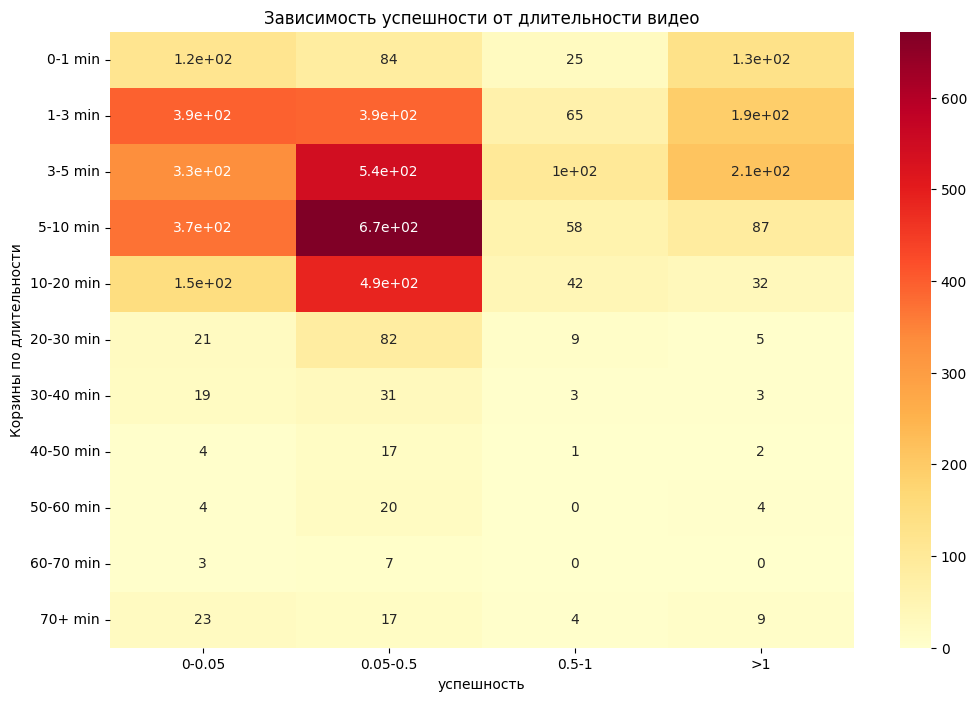

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

pivot_table = pd.pivot_table(df_filtered, index='duration_group', columns='success_group', values='video_id', aggfunc='count', fill_value=0)

print(pivot_table)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap='YlOrRd')

plt.title('Зависимость успешности от длительности видео')
plt.xlabel('успешность')
plt.ylabel('Корзины по длительности')

plt.show()